# 0.   Import data and useful libraries

In [ ]:
# Importing basic packages.
import itertools
import math
import os
import sys
from time import time_ns

# Importing matplotlib.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch
import torch.nn.functional as F
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import hmean
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.metrics.pairwise import cosine_similarity

# Importing sklearn modules.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM

# Importing PyTorch modules.
from torch.autograd import Variable

# np.set_printoptions(formatter={'float': lambda x: "{0:6.2f}".format(x)})

In [ ]:
### Download and extract the data if necessary.
if not os.path.exists("ADFA-LD"):
  !wget -q https://github.com/verazuo/a-labelled-version-of-the-ADFA-LD-dataset/raw/master/ADFA-LD.zip
  !unzip -q ADFA-LD.zip
  !rm ADFA-LD.zip

In [ ]:
# Create directories if necessary.
if not os.path.exists(f"logs"):
    os.makedirs(f"logs")
if not os.path.exists(f"models"):
    os.makedirs(f"models")
    !wget -q https://github.com/Julia185/DORSAL_ADFA-LD/blob/main/skipgram_5.npy
    !wget -q https://github.com/Julia185/DORSAL_ADFA-LD/blob/main/skipgram_10.npy
    !wget -q https://github.com/Julia185/DORSAL_ADFA-LD/blob/main/skipgram_20.npy
if not os.path.exists(f"figures"):
    os.makedirs(f"figures")

In [ ]:
SKIPGRAM_TRAIN = True
N_THRESHOLD = 100

# 1.   Load Data

In this part, we load the different datasets from the ADFA-LD data (training, validation and attack) with the function ``` readFile() ``` . Then, we generate 3 categories from it :

*   Training data
*   Valid data
*   Test data 

Valid and Test categories correspond to the mix of attacks and validation data. They are divided with a 3:7 ratio.
Each category is filled with sequences of system calls : valid and test categories contain anomalies.

In [ ]:
def readFile(path):
    """This function reads all the values of a text file in one folder
    and then stock them in a list.

    Args:
      path (str): File path of the dataset.

    Returns:
        sequences: List of sequences.
    """

    # Make sure that it is a file and not a directory. Additionally, os.path.join
    # is more robust as it will automatically add "/" if necessary.
    list_of_files = [
        os.path.join(path, f) for f in os.listdir(path) if not os.path.isdir(f)
    ]

    # Sequences of syscall.
    sequences = []

    # We go through all the files of the folder.
    for file in sorted(list_of_files):
        with open(file) as f:
            # Convert the string as a sequence of int.
            x = [int(x) for x in f.readline().split(" ") if x != ""]
            # Add list to sequences.
            sequences.append(x)

    return sequences

In [ ]:
### ----------
### Read the data and generate the arrays.
### ----------

### Training data.
X_train = readFile("ADFA-LD/Training_Data_Master")
y_train = [0] * len(X_train)

### Validation data.
X_validation = readFile("ADFA-LD/Validation_Data_Master")
y_validation = [0] * len(X_validation)

### Attack data.
attack_path = "ADFA-LD/Attack_Data_Master"
name_folder = sorted(os.listdir(attack_path))

X_attack, y_attack = [], []

anomaly_to_label = {
    "Normal": 0,
    "Adduser": 1,
    "Hydra FTP": 2,
    "Hydra SSH": 3,
    "Java Meterpreter": 4,
    "Meterpreter": 5,
    "Web Shell": 6,
}

label_to_anomaly = [
    "Normal",
    "Adduser",
    "Hydra FTP",
    "Hydra SSH",
    "Java Meterpreter",
    "Meterpreter",
    "Web Shell",
]

for name in name_folder:
    liste = readFile(os.path.join(attack_path, name))
    X_attack.extend(liste)
    label = anomaly_to_label[" ".join(name.split("_")[:-1])]
    y_attack.extend([label] * len(liste))

### Valid and Test data.
X = X_validation + X_attack
y = y_validation + y_attack
X_valid, X_test, label_valid, label_test = train_test_split(
    X, y, test_size=0.7, stratify=y
)
y_valid = [1 if i > 0 else 0 for i in label_valid]
y_test = [1 if i > 0 else 0 for i in label_test]

In [ ]:
def generate_vocabulary():
    """This function generates the list with all the integers seen in the
       sequences.

    Args:
      sequences (list): data used to generate the list.

    Returns:
        vocab (list): List with all the integers seen in the data.
    """

    vocab = []
    [vocab.append(x) for x in range(341)]
    return vocab

In [ ]:
### Generate the vocabulary vector.
vocab = generate_vocabulary()

# 2.   Data statistics

In [ ]:
print("=" * 30)
print("{:^30s}".format("Normal Data"))
print("=" * 30)

print("{:20s}: {:5d}".format("Training", len(X_train)))
print("{:20s}: {:5d}".format("Validation", len(X_validation)))

print("=" * 30 + f"\n{'Attack Data':^30s}\n" + "=" * 30)

label, count = np.unique(y_attack, return_counts=True)
for l, c in zip(label, count):
    print("{:20s}: {:5d}".format(label_to_anomaly[l], c))

         Normal Data          
Training            :   833
Validation          :  4372
         Attack Data          
Adduser             :    91
Hydra FTP           :   162
Hydra SSH           :   176
Java Meterpreter    :   124
Meterpreter         :    75
Web Shell           :   118


In [ ]:
def stats(dataset):
    """This function computes statistics about the data.

    Args:
      dataset (list): data used for the stats.
    """

    print("{:s} :".format("System Call Sequence Length"))
    print("{:5s}{:20s} : {:10d}".format(" ", "Min", np.min(list(map(len, dataset)))))
    print("{:5s}{:20s} : {:10d}".format(" ", "Max", np.max(list(map(len, dataset)))))
    print(
        "{:5s}{:20s} : {:10.2f}".format(
            " ", "Median", np.median(list(map(len, dataset)))
        )
    )
    print(
        "{:5s}{:20s} : {:10.2f}".format(" ", "Mean", np.mean(list(map(len, dataset))))
    )
    print(
        "{:5s}{:20s} : {:10.2f}".format(
            " ", "Standard Deviation", np.std(list(map(len, dataset)))
        )
    )

    print("\n{:s} :".format("Number of Distinct System Calls"))
    print(
        "{:5s}{:20s} : {:10d}".format(
            " ", "Min", np.min(list(map(len, map(set, dataset))))
        )
    )
    print(
        "{:5s}{:20s} : {:10d}".format(
            " ", "Max", np.max(list(map(len, map(set, dataset))))
        )
    )
    print(
        "{:5s}{:20s} : {:10.2f}".format(
            " ", "Median", np.median(list(map(len, map(set, dataset))))
        )
    )
    print(
        "{:5s}{:20s} : {:10.2f}".format(
            " ", "Mean", np.mean(list(map(len, map(set, dataset))))
        )
    )
    print(
        "{:5s}{:20s} : {:10.2f}".format(
            " ", "Standard Deviation", np.std(list(map(len, map(set, dataset))))
        )
    )
    print("." * 65)
    print("\n")

In [ ]:
print("Training set :\n")
stats(X_train)

print("Valid set :\n")
stats(X_valid)

print("Test set :\n")
stats(X_test)

Training set :

System Call Sequence Length :
     Min                  :         79
     Max                  :       2948
     Median               :     201.00
     Mean                 :     369.84
     Standard Deviation   :     393.44

Number of Distinct System Calls :
     Min                  :          1
     Max                  :         58
     Median               :      18.00
     Mean                 :      18.75
     Standard Deviation   :       8.95
.................................................................


Valid set :

System Call Sequence Length :
     Min                  :         77
     Max                  :       4094
     Median               :     343.00
     Mean                 :     479.14
     Standard Deviation   :     541.14

Number of Distinct System Calls :
     Min                  :          1
     Max                  :         59
     Median               :      22.00
     Mean                 :      19.99
     Standard Deviation   :     

In [ ]:
### Function that provides a graph with the different syscalls
### and the number of times they were called.
def show_occurence(dataset):
    occurence = [0] * 341

    for sequence in dataset:
        label, count = np.unique(sequence, return_counts=True)

        for l, c in zip(label, count):
            occurence[l] += c

    for i, value in enumerate(occurence):
        plt.bar(i, value)

    plt.title("Number of occurence for every system call")
    plt.xlabel("System Calls")
    plt.ylabel("Occurence")
    plt.yscale("log")
    plt.xlim((0, 345))
    plt.ylim((0, 55000))
    plt.show()
    plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


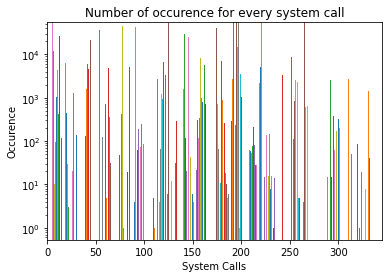

In [ ]:
show_occurence(X_train+X_validation)

We can see on this graph that some syscalls are called a lot more than others.

# 3. Representation

## Bow (Bag of Word)

We will transform the sequences with a bag of words method. We will obtain a count of each system call.

Due to some problems, we will implement manually our vocabulary list.

In [ ]:
def generate_bow(dataset, vocab):
    """This function implements bag of words model.

    Args:
      dataset (list): data used to generate the model.
      vocab (list): vocabulary vector.

    Returns:
        bow (array): Matrix with the results of bow on dataset.
    """

    # Creation of bag of words.
    # 2 dimensions array : len(dataset) x len(vocab)
    bow = np.zeros((len(dataset), len(vocab)))

    for i, sequence in enumerate(dataset):
        for s in sequence:
            if s in vocab:
                bow[i, vocab[s]] += 1

    return bow

In [ ]:
### Generate bow of each dataset.
bow_train_X = generate_bow(X_train, vocab)
bow_valid_X = generate_bow(X_valid, vocab)
bow_test_X = generate_bow(X_test, vocab)

representations = [("Bag of Word", bow_train_X, bow_valid_X, bow_test_X)]

## TF-IDF (Term Frequency Inverse Document Frequency)

This method calculate how important a syscall is in a sequence. 

In [ ]:
def computeTF(bow):
    """This function computes the Term Frequency.
       tf = (Frequency of the syscall in the sequence) / (Total number of syscall in the sequence)

    Args:
      bow (array): bag of word of the dataset.

    Returns:
        tf (array): Term Frequency of each syscall.
    """

    return bow / bow.sum(axis=1).reshape((bow.shape[0], 1))

In [ ]:
def computeIDF(bow):
    """This function computes the Inverse Document Frequency.
       idf = (Total number of sequences)/(Number of sequences containing the syscall)

    Args:
      bow (array): bag of word of the dataset.

    Returns:
        idf (array): inverse document frequency of each syscall.
    """

    epsilon = 1e-9

    # Number of documents that contain each system call.
    count = (bow > 0).astype(int).sum(axis=0)

    return np.log10(bow.shape[0] / (count + epsilon))

In [ ]:
def computeTFIDF(tf, idf):
    """This function computes the tf_idf value of each syscall.
       tf-idf = tf x idf

    Args:
      tf (array): term frequency of each syscall in the sequence.
      idf (array): inverse document frequency of each syscall in the sequence.

    Returns:
        tfidf (array): tf-idf of each syscall in the sequence.
    """

    tfidf = np.array(tf * idf)
    tfidf = np.round(tfidf, 3)

    return tfidf

In [ ]:
### Train set.
tf_train = computeTF(bow_train_X)
idf_train = computeIDF(bow_train_X)
tf_idf_train = computeTFIDF(tf_train, idf_train)

### Valid set.
tf_valid = computeTF(bow_valid_X)
idf_valid = computeIDF(bow_valid_X)
tf_idf_valid = computeTFIDF(tf_valid, idf_valid)

### Test set.
tf_test = computeTF(bow_test_X)
idf_test = computeIDF(bow_test_X)
tf_idf_test = computeTFIDF(tf_test, idf_test)

representations.append(("TF-IDF", tf_idf_train, tf_idf_valid, tf_idf_test))

## LDA (Latent Dirichlet Allocation)

In NPL, the LDA is a topic model : it's a statistical language used to discover themes in a dataset. For example, it's used to classify text in a particular document to a certain topic.

The idea is that we will perform unsupervised classification on different sequence, which find some natural groups in topics. 

In [ ]:
def generate_lda(train_data, pred_data, n_feature):
    """This function implements bag of words model.

    Args:
      train_data (list): data used to generate the model.
      pred_data (list): data to apply the model on.
      n_feature (int): number of topics.

    Returns:
        lda (array): LDA matrix.
    """

    # Initialize LDA.
    lda = LatentDirichletAllocation(n_components=n_feature, random_state=100, n_jobs=-1)

    # Find the best projection on the Train set.
    lda.fit(train_data)

    # Project the dataset.
    lda = lda.transform(pred_data)

    return lda

In [ ]:
for dim in [5, 10, 20]:
    # Project the Train and Valid sets.
    lda_train_X = generate_lda(bow_train_X, bow_train_X, dim)
    lda_valid_X = generate_lda(bow_train_X, bow_valid_X, dim)
    lda_test_X = generate_lda(bow_train_X, bow_test_X, dim)

    representations.append((f"LDA-{dim}", lda_train_X, lda_valid_X, lda_test_X))

## Skip-gram (word2vec)

In [ ]:
def create_idx_pairs(dataset, context_window_size):
    """This function generate pairs (center syscall, context syscall).

    Args:
      dataset (list): data used for the representation.
      context_window_size (int): distance of the context word from the topic word.

    Returns:
        idx_pairs (array): Pair of indexes (topic, context).
    """

    idx_pairs = []

    # For each sequence.
    for sequence in dataset:
        # For each syscall, treated as center word.
        for center_word_pos in range(len(sequence)):
            # For each context window position.
            for w in range(-context_window_size, context_window_size + 1):
                context_word_pos = center_word_pos + w

                # If center word is the first word of the sequence OR
                # if context word index is >= as the max index of the sequence OR
                # if context word is the same as center word.
                if (
                    context_word_pos < 0
                    or context_word_pos >= len(sequence)
                    or center_word_pos == context_word_pos
                ):
                    continue

                # We save the index of the context word.
                # We pair the center word with the context word.
                context_word_idx = sequence[context_word_pos]
                idx_pairs.append((sequence[center_word_pos], context_word_idx))

    return np.array(idx_pairs)

In [ ]:
def create_batch(dataset, batch_size):
    """This function implements the batches of the dataset.

    Args:
      dataset (list): data to be cut into different batch.
      batch_size (int): size of the batch.

    Returns:
        batches (list): list of all the batches from the dataset.
    """

    batches = []
    batch_target, batch_context = [], []

    for i in range(len(dataset)):
        batch_target.append(dataset[i][0])
        batch_context.append(dataset[i][1])

        if (i + 1) % batch_size == 0 or i == len(dataset) - 1:
            tensor_target = Variable(torch.from_numpy(np.array(batch_target)).long())
            tensor_context = Variable(torch.from_numpy(np.array(batch_context)).long())

            batches.append((tensor_target, tensor_context))
            batch_target, batch_context = [], []

    return batches

In [ ]:
def get_input_layer(target):
    """This function generates a matrix of one hot-encoded vector as input layer.

    Args:
      target (int): system call we want to predict the context.

    Returns:
        input (tensor): one-hot encoded vector of the target.
    """

    input = torch.zeros([len(target), len(vocab)], dtype=torch.float)

    for i, x in enumerate(target):
        input[i, x] = 1.0

    return input

In [ ]:
def skipgram(
    X_train,
    X_valid,
    dimension,
    n_updates=None,
    train=False,
    patience=5,
    batch=32,
    n_eval=1000,
):
    if train:
        # Generate the batches.
        train_batch = create_batch(create_idx_pairs(X_train, 2), batch)
        valid_batch = create_batch(create_idx_pairs(X_valid, 2), batch)

        # Device is always CPU since GPU is slower.
        device = torch.device("cpu")

        # Hidden Layer.
        # Corresponds to our v vectors (context).
        # It needs to have embedding_dims neurons.
        embedding_dims = dimension

        # To compute its value, we need to define W1 weight matrix (embedding_dims, vocabulary_size).
        # Each column of W1 stores v vector for single word.
        W1 = torch.randn(
            (len(vocab), embedding_dims), requires_grad=True, device=device
        )

        # Output Layer.
        # It generates probability for each syscall so it has vocab_size neurons.
        # W2 has (vocabulary_size, embedding_dims) shape.
        W2 = torch.randn(
            (embedding_dims, len(vocab)), requires_grad=True, device=device
        )

        # Construct an optimizer.
        # lr = learning rate.
        # [var1, var2] = weight vectors.
        optimizer = torch.optim.Adam([W1, W2], lr=0.001)

        # Open the log file.
        logfile = open(f"logs/skipgram_{dimension}.txt", "w")

        avg_t, epoch, update, eval_since_best = 0, 0, 0, 0
        best_val_loss = sys.maxsize
        train_loss, val_loss = [], []
        n_samples = len(train_batch)
        start = time_ns()

        while True:
            epoch += 1
            for target, context in train_batch:
                # To keep track of the model's progress.
                update += 1

                input = Variable(get_input_layer(target)).float()
                # print("input : ", input.shape)

                y_true = Variable(context).long()
                # print("y_true : ", y_true.shape)

                z1 = torch.matmul(input, W1)
                # print("z1 : ", z1.shape)

                z2 = torch.matmul(z1, W2)
                # print("z2 : ", z2.shape)

                # We use the function softmax and then apply the log function.
                y_pred = F.log_softmax(z2, dim=1)
                # print("log softmax : ", x.shape)

                # nll_loss computes negative-log-likelihood on logsoftmax.
                loss = F.nll_loss(y_pred, y_true)
                train_loss.append(loss.item())

                # Reset gradient, perform backward pass and update the model.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Save the model every n_eval updates.
                if update % n_eval == 0:

                    # Compute average time per batch in ms.
                    avg_t = (time_ns() - start) / (n_eval * 1e6)

                    # Evaluate the model on the validation set.
                    # We indicate we don't need the gradient to be save.
                    with torch.no_grad():
                        # for target, context in itertools.islice(valid_batch, 100):
                        for target, context in valid_batch:
                            input = Variable(get_input_layer(target)).float()
                            y_true = Variable(context).long()
                            z1 = torch.matmul(input, W1)
                            z2 = torch.matmul(z1, W2)
                            y_pred = F.log_softmax(z2, dim=1)
                            loss = F.nll_loss(y_pred, y_true)
                            val_loss.append(loss.item())

                    line = (
                        "Updates {:6d} ".format(update)
                        + "(epoch {:d} ".format(epoch)
                        + "@ {:4.2f} ms/batch) ".format(avg_t)
                        + "train_loss {:2.3f} ".format(np.mean(train_loss))
                        + "val_loss {:2.3f}".format(np.mean(val_loss))
                    )
                    print(line)
                    logfile.write(line + "\n")

                    # Early stopping.
                    if np.mean(val_loss) < (best_val_loss - 0.001):
                        best_val_loss = np.mean(val_loss)
                        eval_since_best = 0
                    else:
                        eval_since_best += 1

                    # Re-initialize loss_val.
                    train_loss, val_loss = [], []
                    start = time_ns()

                # Exit the batch loop.
                if (
                    n_updates is not None and update > n_updates
                ) or eval_since_best > patience:
                    break

            # Exit the epoch loop.
            if (
                n_updates is not None and update > n_updates
            ) or eval_since_best > patience:
                break

        # Get the embedding.
        W = W1.detach().numpy()
        with open(f"models/skipgram_{dimension}.npy", "wb") as f:
            np.save(f, W)

        # Close log file.
        logfile.close()

    # Load the embedding.
    W = np.load(f"models/skipgram_{dimension}.npy")

    skip_train_sum, skip_train_mean = [], []
    skip_valid_sum, skip_valid_mean = [], []
    skip_test_sum, skip_test_mean = [], []

    for sequence in X_train:
        skip_train_sum.append(np.sum(W[sequence], axis=0))
        skip_train_mean.append(np.mean(W[sequence], axis=0))

    for sequence in X_valid:
        skip_valid_sum.append(np.sum(W[sequence], axis=0))
        skip_valid_mean.append(np.mean(W[sequence], axis=0))

    for sequence in X_test:
        skip_test_sum.append(np.sum(W[sequence], axis=0))
        skip_test_mean.append(np.mean(W[sequence], axis=0))

    skip_train_sum = np.array(skip_train_sum)
    skip_train_mean = np.array(skip_train_mean)
    skip_valid_sum = np.array(skip_valid_sum)
    skip_valid_mean = np.array(skip_valid_mean)
    skip_test_sum = np.array(skip_test_sum)
    skip_test_mean = np.array(skip_test_mean)

    return (
        skip_train_sum,
        skip_train_mean,
        skip_valid_sum,
        skip_valid_mean,
        skip_test_sum,
        skip_test_mean,
    )

In [ ]:
for dim in [5, 10, 20]:
    (
        skip_train_sum,
        skip_train_mean,
        skip_valid_sum,
        skip_valid_mean,
        skip_test_sum,
        skip_test_mean,
    ) = skipgram(X_train, X_valid, dim, train=SKIPGRAM_TRAIN)

    representations.append(
        (f"SkipGram-Sum-{dim}", skip_train_sum, skip_valid_sum, skip_test_sum)
    )
    representations.append(
        (f"SkipGram-Mean-{dim}", skip_train_mean, skip_valid_mean, skip_test_mean)
    )

Updates   1000 (epoch 1 @ 0.99 ms/batch) train_loss 6.935 val_loss 6.459
Updates   2000 (epoch 1 @ 0.76 ms/batch) train_loss 5.412 val_loss 5.188
Updates   3000 (epoch 1 @ 0.75 ms/batch) train_loss 4.174 val_loss 4.172
Updates   4000 (epoch 1 @ 0.74 ms/batch) train_loss 3.723 val_loss 3.661
Updates   5000 (epoch 1 @ 0.76 ms/batch) train_loss 2.348 val_loss 3.572
Updates   6000 (epoch 1 @ 0.77 ms/batch) train_loss 2.012 val_loss 3.698
Updates   7000 (epoch 1 @ 0.79 ms/batch) train_loss 1.869 val_loss 3.585
Updates   8000 (epoch 1 @ 0.78 ms/batch) train_loss 2.318 val_loss 3.450
Updates   9000 (epoch 1 @ 0.76 ms/batch) train_loss 1.865 val_loss 3.474
Updates  10000 (epoch 1 @ 0.76 ms/batch) train_loss 1.470 val_loss 3.339
Updates  11000 (epoch 1 @ 0.77 ms/batch) train_loss 1.755 val_loss 3.185
Updates  12000 (epoch 1 @ 0.76 ms/batch) train_loss 2.398 val_loss 3.061
Updates  13000 (epoch 1 @ 0.77 ms/batch) train_loss 2.433 val_loss 3.104
Updates  14000 (epoch 1 @ 0.75 ms/batch) train_loss

# 4.   Outlier Detection System

## Functions

In [ ]:
def metrics(y_true, y_pred, name):
    print(f"{name}:")
    print(
        f"\t{'Accuracy:':12s} {accuracy_score(y_true, y_pred):.2%}",
        f"\t{'Precision:':12s} {precision_score(y_true, y_pred):.2%}",
        f"\t{'Recall:':12s} {recall_score(y_true, y_pred):.2%}",
        f"\t{'F1-score:':12s} {f1_score(y_true, y_pred):.2%}",
        sep="\n",
    )

In [ ]:
def threshold(score, y_true):
    """This function computes the machine learning metrics
       for different thresholds.

    Args:
      score (list): dataset used to measure the y_pred vector.
      y_true (list): dataset used to calculate the y_true vector.

    Returns:
      thresholds[np.argmax(f1)] (float): thresholds that gives the best f1_score.
    """

    acc, precision, recall, f1 = [], [], [], []
    thresholds = np.arange(
        min(score), max(score), step=(max(score) - min(score)) / N_THRESHOLD
    )

    for t in thresholds:
        # Considered as an anomaly if score is above the threshold.
        y_pred = [1 if x > t else 0 for x in score]

        acc.append(accuracy_score(y_true, y_pred))
        precision.append(precision_score(y_true, y_pred))
        recall.append(recall_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))

    return thresholds[np.argmax(f1)]

In [ ]:
def show_confusion_matrix(y_true, y_pred, name=""):
    """This function determines the confusion matrix and save it.

    Args:
      y_true (list): true value of the targets.
      y_pred (list) : estimated targets returned by the model.
      name (str) : name of the method used to obtain y_pred.
    """

    conf_matrix = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Purples, alpha=0.5)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(
                x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large"
            )

    plt.title(f"Confusion Matrix - {name}", fontsize=18)
    plt.xlabel("Predictions", fontsize=18)
    plt.ylabel("Actuals", fontsize=18)

    fig.savefig(f"figures/Confusion_Matrix_{name}.pdf")
    plt.close()

In [ ]:
def plot_roc_curve(y_valid, score, name=""):
    """This function shows the ROC curve.

    Args:
      y_valid (list): array with the type of syscall.
      score (list) : prediction score of the data.
      name (str) : name of the method used to obtain fpr and tpr.
    """

    # Create figure.
    fig = plt.figure(figsize=(6, 6), tight_layout=True)
    ax = fig.add_subplot(111)

    # Set colors.
    dark_gray = "#808080"

    # Hide the right and top spines.
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Change axes and tick color.
    ax.spines["bottom"].set_color(dark_gray)
    ax.tick_params(axis="x", colors=dark_gray)
    ax.spines["left"].set_color(dark_gray)
    ax.tick_params(axis="y", colors=dark_gray)
    ax.xaxis.label.set_color(dark_gray)
    ax.yaxis.label.set_color(dark_gray)

    # Plot.
    fpr, tpr, thresholds = roc_curve(y_valid, score)
    auroc = roc_auc_score(y_valid, score)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color=dark_gray, lw=1)

    # Change limit.
    plt.xlim((0, 1))
    plt.ylim((0, 1))

    # Labels.
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Make title the length of the graph.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="9%", pad=0)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    for x in cax.spines:
        cax.spines[x].set_visible(False)
    cax.spines["top"].set_visible(False)
    cax.set_facecolor(dark_gray)
    at = AnchoredText(
        f"{name} (AUROC: {auroc:.2f})",
        loc=6,
        pad=0,
        prop=dict(backgroundcolor=dark_gray, size=14, color="w"),
    )
    at.patch.set_edgecolor("none")
    cax.add_artist(at)

    # Display figure.
    plt.savefig(f"figures/{name}.pdf")
    plt.show()
    plt.close()

## Cosine Similarity

In this part, we try to detect outliers within our dataset with a geometry-based method : the cosine_similarity. 
Once we've determined the best threshold for our validation set, we try our outlier detection system on our test set. 
You can see the confusion matrix for both set.

In [ ]:
def cos_sim(fit_data, pred_data, y_data):
    """
    This function train on fit_data then make predictions about pred_data
    to find outliers using Cosine Similarity method.

    Args:
      fit_data (list): data used for training the model.
      pred_data (list): data with outlier, to compare to train_data.
      y_data (list): array with the type of syscall.

    Returns:
      y_pred (float) : estimated targets returned by the model.
      cos (list) : cosine similarity score.
    """

    cos = cosine_similarity(fit_data, pred_data, y_data)
    cos = 1 - np.mean(cos, axis=0)
    best_threshold = threshold(cos, y_data)

    y_pred = [1 if s > best_threshold else 0 for s in cos]

    return y_pred, cos, None, best_threshold

## KNN (K Nearest Neighbors)

In [ ]:
def KNN(fit_data, pred_data, y_data, method="exact"):
    """
    This function train on fit_data then make predictions about pred_data
    to find outliers using K Nearest Neighbors method.

    Args:
      fit_data (list): data used for training the model.
      pred_data (list): data with outlier, to compare to train_data.
      y_data (list): array with the type of syscall.

    Returns:
      y_pred (list): estimated targets returned by the model.
      score (list): KNN score.
    """

    best_f1, best_k, best_t = 0, 0, 0

    # Tests a few number of neighbors.
    for k in range(1, 50, 2):
        neigh = NearestNeighbors(n_neighbors=k, n_jobs=-1)
        neigh.fit(fit_data)

        # D : distance, _ : index
        D, _ = neigh.kneighbors(pred_data)

        if method.lower() == "exact":
            # Consider only the distance to the k-NN.
            score = D[:, -1]
        elif method.lower() == "mean":
            # Compute the mean of the distance to the k-NNs.
            score = np.mean(D, axis=1)
        elif method.lower() == "hmean":
            # Compute the harmonic mean of the distance to the k-NNs.
            score = hmean(D, axis=1)

        # Find the threshold that yields the best f1_score.
        for t in np.arange(
            min(score), max(score), step=(max(score) - min(score)) / 100
        ):
            y_pred = [1 if s > t else 0 for s in score]

            if f1_score(y_data, y_pred) > best_f1:
                best_f1 = f1_score(y_data, y_pred)
                best_k = k
                best_t = t

    # We predict with the best parameters found above.
    neigh = NearestNeighbors(n_neighbors=best_k, n_jobs=-1)
    neigh.fit(fit_data)
    D, _ = neigh.kneighbors(pred_data)
    if method.lower() == "exact":
        # Consider only the distance to the k-NN.
        score = D[:, -1]
    elif method.lower() == "mean":
        # Compute the mean of the distance to the k-NNs.
        score = np.mean(D, axis=1)
    elif method.lower() == "hmean":
        # Compute the harmonic mean of the distance to the k-NNs.
        score = hmean(D, axis=1)
    y_pred = [1 if s > best_t else 0 for s in score]

    return y_pred, score, neigh, best_t

## DBSCAN

Density Base Spatial Clustering of Applications with Noise (DBSCAN) is a density-based clustering non-parametric algorithm. Given a set of points in some space, it groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions.

In [ ]:
def DBscan(fit_data, pred_data, y_data):
    """
    This function train on fit_data then make predictions about pred_data
    to find outliers using DBSCAN method.

    Args:
      fit_data (list): data used for training the model.
      pred_data (list): data with outlier, to compare to train_data.
      y_data (list): array with the type of syscall.

    Returns:
      y_pred (list) : estimated targets returned by the model.
    """

    range_eps = np.concatenate(
        (
            np.arange(0.01, 0.1, step=0.01),
            np.arange(0.1, 1, step=0.1),
            np.arange(1, 10, step=1),
        )
    )
    range_min_samples = np.arange(2, 100, step=2)

    best_f1, y_pred = -1, []
    best_eps, best_min_sample = 0, 0

    # Format our dataset.
    X = np.concatenate((fit_data, pred_data), axis=0)

    # Test different value of epsilon and min_samples.
    for e, m in itertools.product(range_eps, range_min_samples):
        # Initialize DBSCAN.
        dbscan = DBSCAN(eps=e, min_samples=m, n_jobs=-1)

        # Compute clusters from our data matrix and predict labels.
        dbscan.fit(X)

        # We predict our labels for our valid set.
        x = [1 if i == -1 else 0 for i in dbscan.labels_[fit_data.shape[0] :]]

        if f1_score(y_data, x) > best_f1:
            best_f1 = f1_score(y_data, x)
            y_pred = x
            best_eps = e
            best_min_sample = m

    return y_pred, None, (best_eps, best_min_sample), None

In [ ]:
# %%timeit -n 10

# range_eps = np.arange(0.1, 1, step=0.1)
# range_min_samples = np.arange(1, 10000, step=1)

# total = 0

# for e, m in itertools.product(range_eps, range_min_samples):
#   total += e**m

## Isolation Forest

In [ ]:
def iso_forest(fit_data, pred_data, y_data):
    """
    This function train on fit_data then make predictions about pred_data
    to find outliers using Isolation Forest method.

    Args:
      fit_data (list): data used for training the model.
      pred_data (list): data with outlier, to compare to train_data.
      y_data (list): array with the type of syscall.

    Returns:
      y_pred (list): estimated targets returned by the model.
      clf_score (list) : isolation forest score.
    """

    clf = IsolationForest(
        n_estimators=100, max_features=1.0, bootstrap=True, random_state=0, n_jobs=-1
    ).fit(fit_data)
    clf_score = -1 * clf.score_samples(pred_data)
    best_threshold = threshold(clf_score, y_data)

    y_pred = [1 if s > best_threshold else 0 for s in clf_score]

    return y_pred, clf_score, clf, best_threshold

## One Class SVM

In [ ]:
def svm(fit_data, pred_data, y_data):
    """
    This function train on fit_data then make predictions about pred_data
    to find outliers using One Class SVM method.

    Args:
      fit_data (list): data used for training the model.
      pred_data (list): data with outlier, to compare to train_data.
      y_data (list): array with the type of syscall.

    Returns:
      y_pred (list): estimated targets returned by the model.
      clf_score (list) : One Class SVM score.
    """

    clf = OneClassSVM().fit(fit_data)
    clf_score = -1 * clf.score_samples(pred_data)
    best_threshold = threshold(clf_score, y_data)

    y_pred = [1 if s > best_threshold else 0 for s in clf_score]

    return y_pred, clf_score, clf, best_threshold

# 5. Results per method

## Cosine Similarity

                                      Bag of Word                                       
Validation:
	Accuracy:    82.67%
	Precision:   43.09%
	Recall:      58.48%
	F1-score:    49.62%


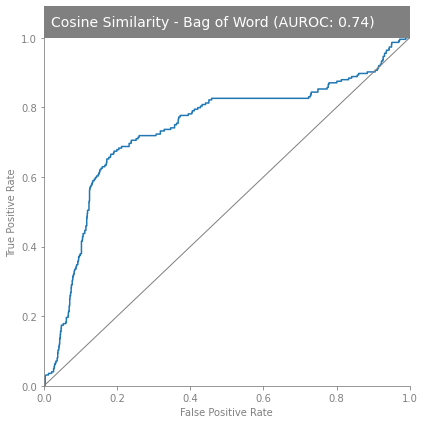

Test:
	Accuracy:    82.33%
	Precision:   42.47%
	Recall:      59.96%
	F1-score:    49.72%
	auROC:       72.86%
                                         TF-IDF                                         
Validation:
	Accuracy:    68.08%
	Precision:   28.55%
	Recall:      79.02%
	F1-score:    41.94%


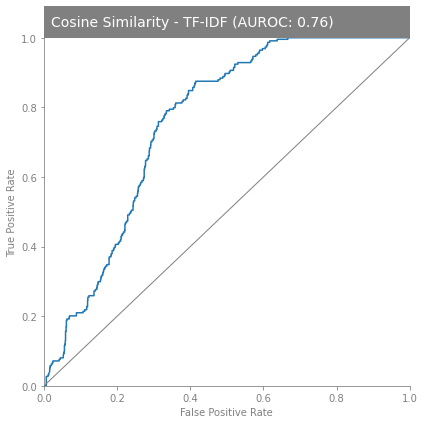

Test:
	Accuracy:    67.32%
	Precision:   27.42%
	Recall:      75.48%
	F1-score:    40.22%
	auROC:       74.62%
                                         LDA-5                                          
Validation:
	Accuracy:    64.63%
	Precision:   24.56%
	Recall:      68.75%
	F1-score:    36.19%


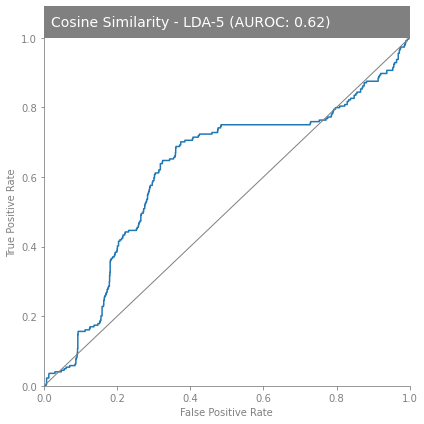

Test:
	Accuracy:    64.53%
	Precision:   24.44%
	Recall:      68.58%
	F1-score:    36.03%
	auROC:       64.39%
                                         LDA-10                                         
Validation:
	Accuracy:    71.07%
	Precision:   29.40%
	Recall:      70.09%
	F1-score:    41.42%


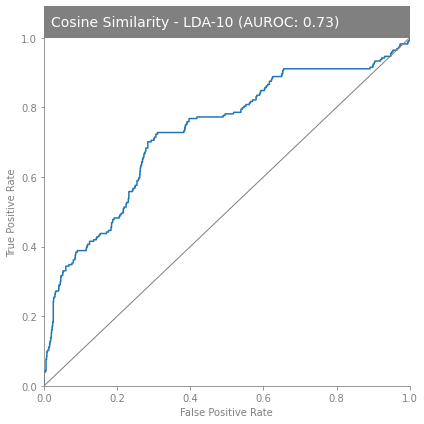

Test:
	Accuracy:    70.92%
	Precision:   28.93%
	Recall:      68.39%
	F1-score:    40.66%
	auROC:       73.17%
                                         LDA-20                                         
Validation:
	Accuracy:    75.96%
	Precision:   31.92%
	Recall:      57.14%
	F1-score:    40.96%


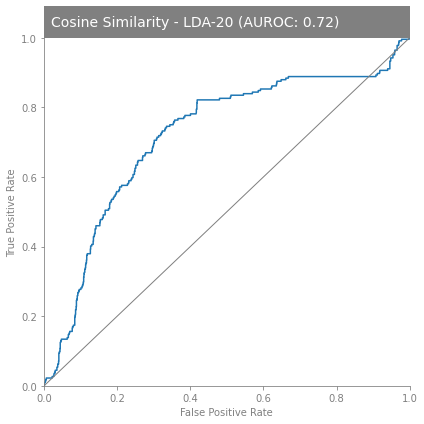

Test:
	Accuracy:    75.33%
	Precision:   31.38%
	Recall:      58.43%
	F1-score:    40.83%
	auROC:       71.24%
                                     SkipGram-Sum-5                                     


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation:
	Accuracy:    79.35%
	Precision:   34.65%
	Recall:      46.88%
	F1-score:    39.85%


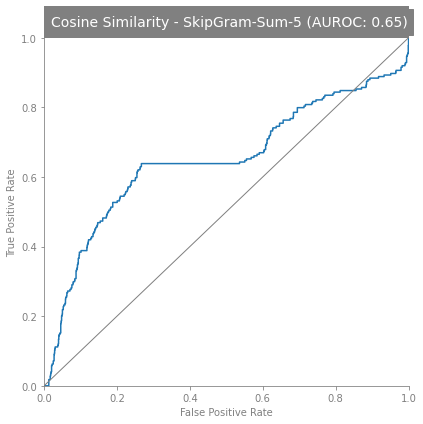

Test:
	Accuracy:    79.79%
	Precision:   35.81%
	Recall:      48.85%
	F1-score:    41.33%
	auROC:       65.95%
                                    SkipGram-Mean-5                                     
Validation:
	Accuracy:    79.35%
	Precision:   34.65%
	Recall:      46.88%
	F1-score:    39.85%


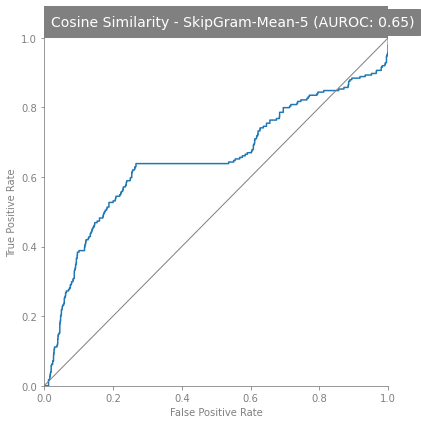

Test:
	Accuracy:    79.79%
	Precision:   35.81%
	Recall:      48.85%
	F1-score:    41.33%
	auROC:       65.95%
                                    SkipGram-Sum-10                                     
Validation:
	Accuracy:    82.15%
	Precision:   42.77%
	Recall:      66.07%
	F1-score:    51.93%


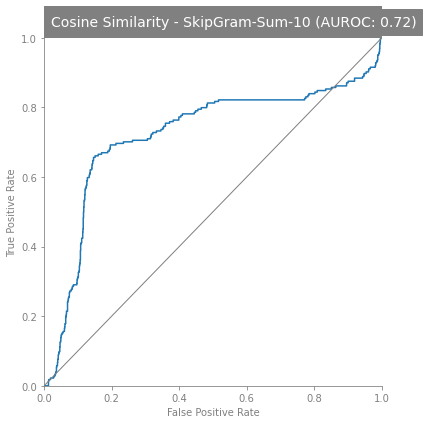

Test:
	Accuracy:    80.83%
	Precision:   39.90%
	Recall:      62.45%
	F1-score:    48.69%
	auROC:       72.28%
                                    SkipGram-Mean-10                                    
Validation:
	Accuracy:    82.15%
	Precision:   42.77%
	Recall:      66.07%
	F1-score:    51.93%


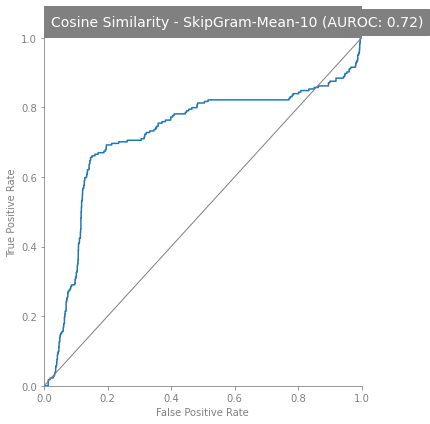

Test:
	Accuracy:    80.83%
	Precision:   39.90%
	Recall:      62.45%
	F1-score:    48.69%
	auROC:       72.28%
                                    SkipGram-Sum-20                                     
Validation:
	Accuracy:    76.48%
	Precision:   34.25%
	Recall:      66.52%
	F1-score:    45.22%


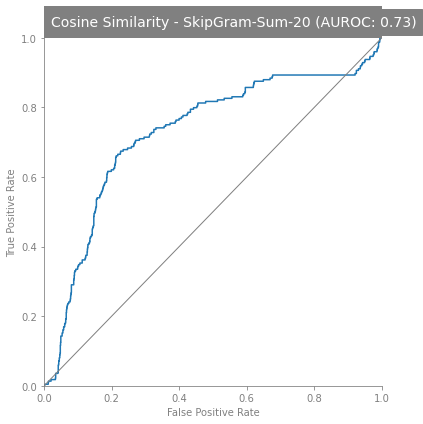

Test:
	Accuracy:    75.55%
	Precision:   32.88%
	Recall:      65.13%
	F1-score:    43.70%
	auROC:       72.98%
                                    SkipGram-Mean-20                                    
Validation:
	Accuracy:    76.48%
	Precision:   34.25%
	Recall:      66.52%
	F1-score:    45.22%


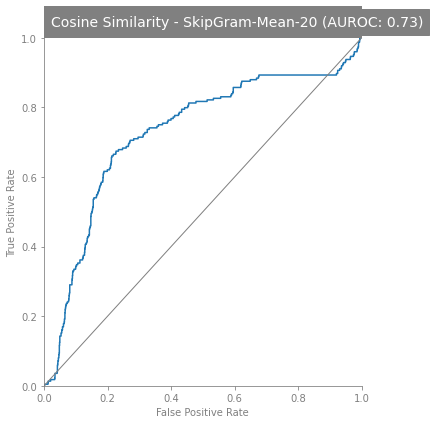

Test:
	Accuracy:    75.55%
	Precision:   32.88%
	Recall:      65.13%
	F1-score:    43.70%
	auROC:       72.98%


In [ ]:
for name, train, valid, test in representations:
    # Header.
    print("=" * 88 + f"\n{name:^88}\n" + "=" * 88)

    # Prediction.
    y_pred, score, _, best_t = cos_sim(train, valid, y_valid)

    # Metrics.
    metrics(y_valid, y_pred, "Validation")

    # Plots.
    show_confusion_matrix(y_valid, y_pred)
    plot_roc_curve(y_valid, score, f"Cosine Similarity - {name}")

    # Predict on the test set.
    score = 1 - np.mean(cosine_similarity(train, test), axis=0)
    y_pred = [1 if s > best_t else 0 for s in score]

    # Metrics.
    metrics(y_test, y_pred, "Test")
    print(f"\t{'auROC:':12s} {roc_auc_score(y_test, score):.2%}")

## KNN

                                      Bag of Word                                       
Validation:
	Accuracy:    75.31%
	Precision:   29.97%
	Recall:      51.79%
	F1-score:    37.97%


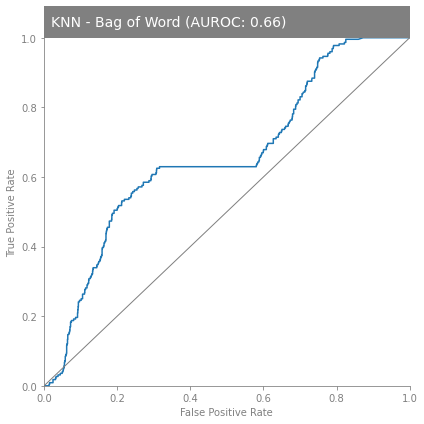

Test:
	Accuracy:    74.52%
	Precision:   28.59%
	Recall:      50.00%
	F1-score:    36.38%
	auROC:       64.48%
                                         TF-IDF                                         
Validation:
	Accuracy:    77.72%
	Precision:   35.82%
	Recall:      66.52%
	F1-score:    46.56%


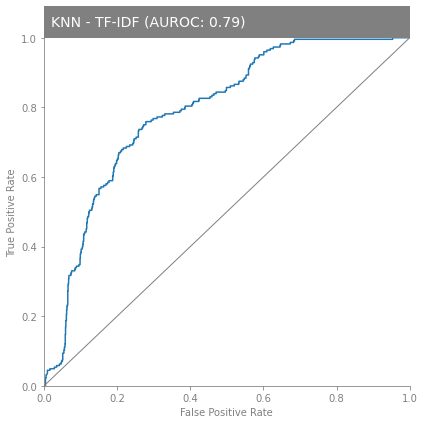

Test:
	Accuracy:    75.10%
	Precision:   32.48%
	Recall:      65.71%
	F1-score:    43.47%
	auROC:       76.25%
                                         LDA-5                                          
Validation:
	Accuracy:    71.14%
	Precision:   28.57%
	Recall:      65.18%
	F1-score:    39.73%


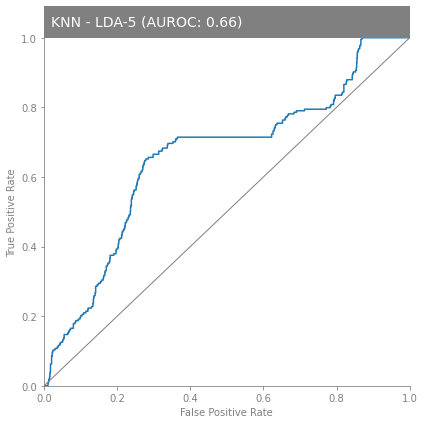

Test:
	Accuracy:    63.97%
	Precision:   22.59%
	Recall:      60.73%
	F1-score:    32.94%
	auROC:       58.95%
                                         LDA-10                                         
Validation:
	Accuracy:    76.68%
	Precision:   35.43%
	Recall:      72.77%
	F1-score:    47.66%


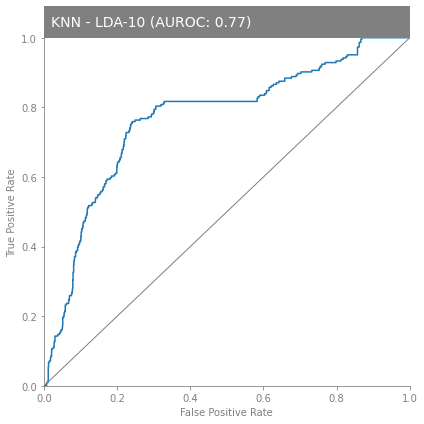

Test:
	Accuracy:    72.20%
	Precision:   30.02%
	Recall:      68.20%
	F1-score:    41.69%
	auROC:       70.39%
                                         LDA-20                                         
Validation:
	Accuracy:    79.93%
	Precision:   39.06%
	Recall:      66.96%
	F1-score:    49.34%


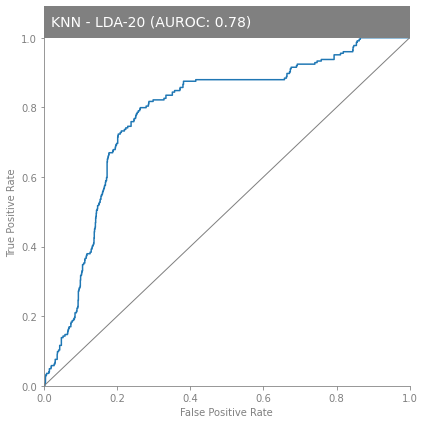

Test:
	Accuracy:    78.15%
	Precision:   36.07%
	Recall:      64.75%
	F1-score:    46.33%
	auROC:       75.45%
                                     SkipGram-Sum-5                                     
Validation:
	Accuracy:    70.36%
	Precision:   25.37%
	Recall:      53.12%
	F1-score:    34.34%


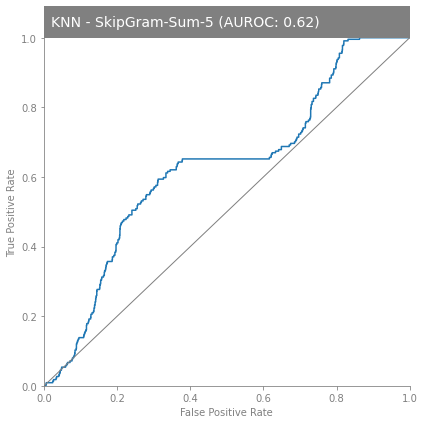

Test:
	Accuracy:    70.33%
	Precision:   25.21%
	Recall:      52.68%
	F1-score:    34.10%
	auROC:       61.68%
                                    SkipGram-Mean-5                                     
Validation:
	Accuracy:    86.84%
	Precision:   54.37%
	Recall:      61.16%
	F1-score:    57.56%


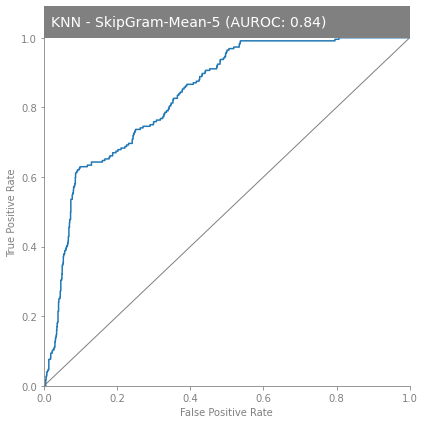

Test:
	Accuracy:    85.18%
	Precision:   49.33%
	Recall:      63.03%
	F1-score:    55.34%
	auROC:       80.66%
                                    SkipGram-Sum-10                                     
Validation:
	Accuracy:    69.51%
	Precision:   25.00%
	Recall:      54.46%
	F1-score:    34.27%


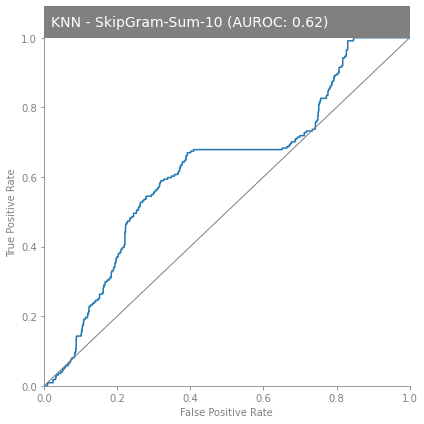

Test:
	Accuracy:    67.51%
	Precision:   23.47%
	Recall:      54.41%
	F1-score:    32.79%
	auROC:       58.21%
                                    SkipGram-Mean-10                                    
Validation:
	Accuracy:    78.83%
	Precision:   37.08%
	Recall:      64.73%
	F1-score:    47.15%


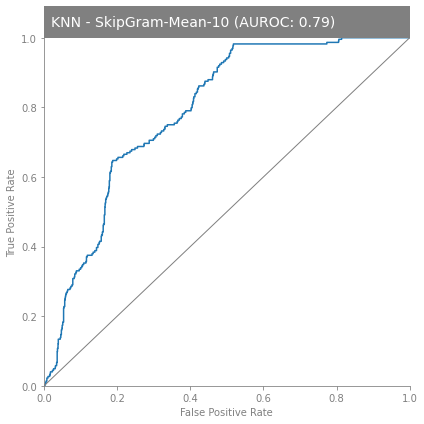

Test:
	Accuracy:    74.69%
	Precision:   32.19%
	Recall:      66.67%
	F1-score:    43.42%
	auROC:       73.92%
                                    SkipGram-Sum-20                                     
Validation:
	Accuracy:    72.77%
	Precision:   27.65%
	Recall:      53.57%
	F1-score:    36.47%


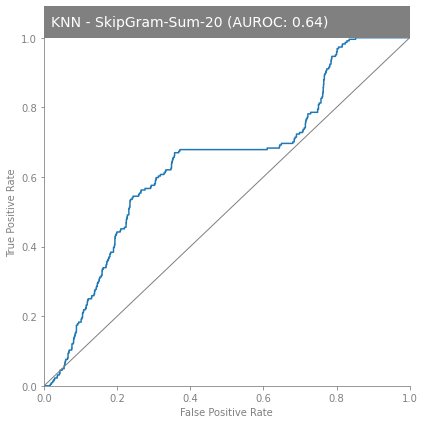

Test:
	Accuracy:    70.95%
	Precision:   25.68%
	Recall:      52.49%
	F1-score:    34.49%
	auROC:       60.62%
                                    SkipGram-Mean-20                                    
Validation:
	Accuracy:    80.00%
	Precision:   38.87%
	Recall:      64.73%
	F1-score:    48.58%


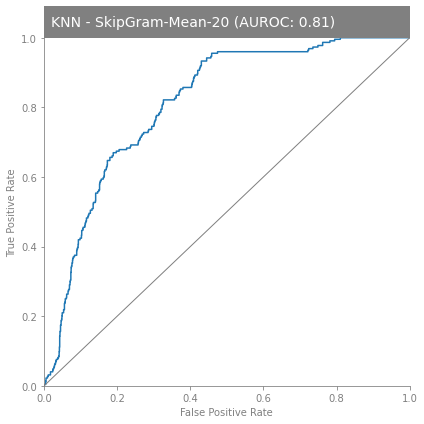

Test:
	Accuracy:    76.84%
	Precision:   34.16%
	Recall:      63.60%
	F1-score:    44.44%
	auROC:       76.95%


In [ ]:
for name, train, valid, test in representations:
    # Header.
    print("=" * 88 + f"\n{name:^88}\n" + "=" * 88)

    # Prediction.
    y_pred, score, model, best_t = KNN(train, valid, y_valid, "hmean")

    # Metrics.
    metrics(y_valid, y_pred, "Validation")

    # Plots.
    show_confusion_matrix(y_valid, y_pred)
    plot_roc_curve(y_valid, score, f"KNN - {name}")

    # Predict on the test set.
    D, _ = model.kneighbors(test)
    score = np.mean(D, axis=1)
    y_pred = [1 if s > best_t else 0 for s in score]

    # Metrics.
    metrics(y_test, y_pred, "Test")
    print(f"\t{'auROC:':12s} {roc_auc_score(y_test, score):.2%}")

## DBSCAN

In [ ]:
for name, train, valid, test in representations:
    # Header.
    print("=" * 88 + f"\n{name:^88}\n" + "=" * 88)

    # Prediction.
    y_pred, _, (e, m), _ = DBscan(train, valid, y_valid)

    # Metrics.
    metrics(y_valid, y_pred, "Validation")

    # Plots.
    show_confusion_matrix(y_valid, y_pred)

    # Format our dataset.
    X = np.concatenate((train, test), axis=0)

    # Initialize DBSCAN.
    model = DBSCAN(eps=e, min_samples=m, n_jobs=-1)

    # Compute clusters from our data matrix and predict labels.
    model.fit(X)

    # We predict our labels for our valid set.
    y_pred = [1 if i == -1 else 0 for i in model.labels_[-test.shape[0] :]]

    # Metrics.
    metrics(y_test, y_pred, "Test")

                                      Bag of Word                                       
Validation:
	Accuracy:    68.66%
	Precision:   30.73%
	Recall:      91.52%
	F1-score:    46.02%
Test:
	Accuracy:    73.74%
	Precision:   34.16%
	Recall:      86.59%
	F1-score:    49.00%
                                         TF-IDF                                         
Validation:
	Accuracy:    72.51%
	Precision:   31.53%
	Recall:      75.45%
	F1-score:    44.47%
Test:
	Accuracy:    76.64%
	Precision:   32.56%
	Recall:      56.32%
	F1-score:    41.26%
                                         LDA-5                                          
Validation:
	Accuracy:    69.38%
	Precision:   27.05%
	Recall:      64.73%
	F1-score:    38.16%
Test:
	Accuracy:    73.10%
	Precision:   27.36%
	Recall:      51.15%
	F1-score:    35.65%
                                         LDA-10                                         
Validation:
	Accuracy:    64.89%
	Precision:   24.64%
	Recall:      68.30%
	F1-score: 

## Isolation Forest

                                      Bag of Word                                       
Validation:
	Accuracy:    46.51%
	Precision:   17.45%
	Recall:      71.43%
	F1-score:    28.05%


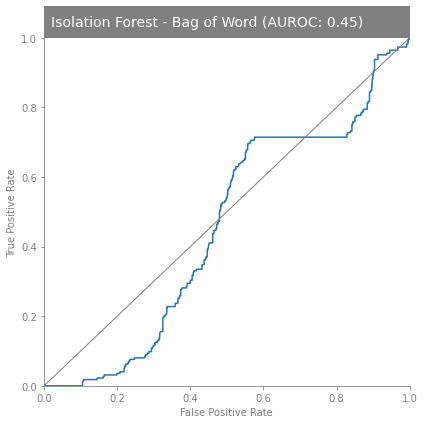

Test:
	Accuracy:    48.37%
	Precision:   18.59%
	Recall:      75.29%
	F1-score:    29.82%
	auROC:       48.36%
                                         TF-IDF                                         
Validation:
	Accuracy:    40.39%
	Precision:   16.68%
	Recall:      77.23%
	F1-score:    27.44%


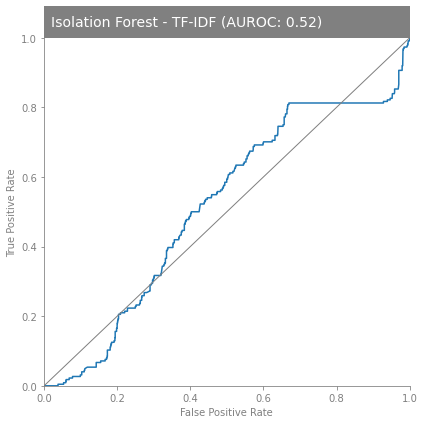

Test:
	Accuracy:    41.28%
	Precision:   16.65%
	Recall:      75.67%
	F1-score:    27.30%
	auROC:       51.06%
                                         LDA-5                                          
Validation:
	Accuracy:    66.58%
	Precision:   24.69%
	Recall:      62.95%
	F1-score:    35.47%


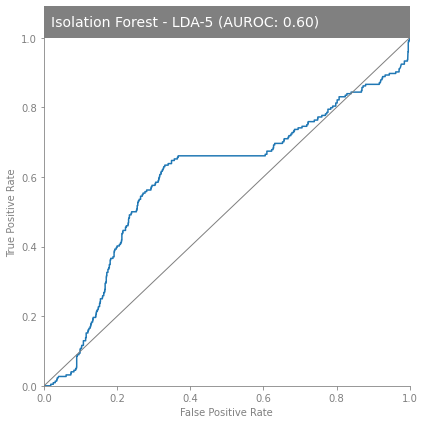

Test:
	Accuracy:    65.20%
	Precision:   23.21%
	Recall:      60.15%
	F1-score:    33.49%
	auROC:       57.30%
                                         LDA-10                                         
Validation:
	Accuracy:    82.61%
	Precision:   40.53%
	Recall:      41.07%
	F1-score:    40.80%


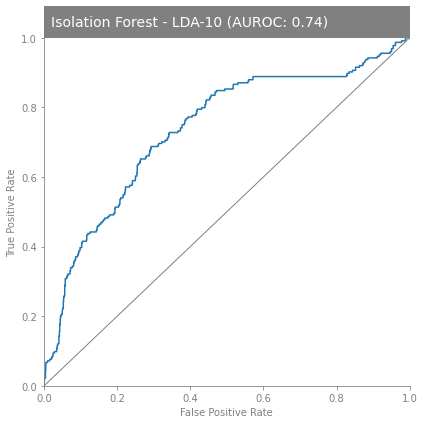

Test:
	Accuracy:    81.55%
	Precision:   37.39%
	Recall:      39.46%
	F1-score:    38.40%
	auROC:       72.07%
                                         LDA-20                                         
Validation:
	Accuracy:    81.24%
	Precision:   40.96%
	Recall:      64.73%
	F1-score:    50.17%


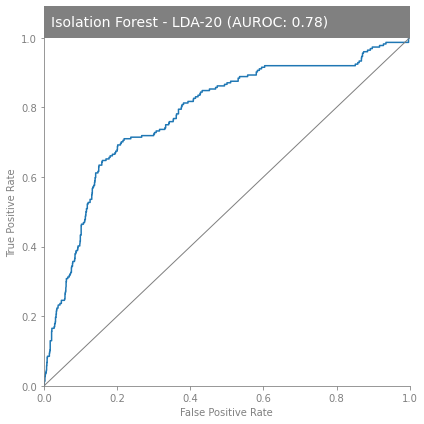

Test:
	Accuracy:    81.94%
	Precision:   42.00%
	Recall:      62.84%
	F1-score:    50.35%
	auROC:       74.89%
                                     SkipGram-Sum-5                                     
Validation:
	Accuracy:    69.06%
	Precision:   23.01%
	Recall:      47.77%
	F1-score:    31.06%


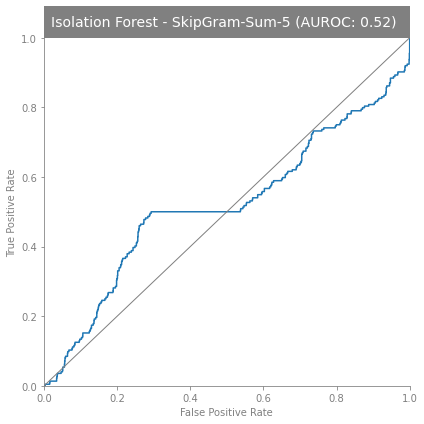

Test:
	Accuracy:    69.83%
	Precision:   23.30%
	Recall:      46.74%
	F1-score:    31.10%
	auROC:       52.25%
                                    SkipGram-Mean-5                                     
Validation:
	Accuracy:    73.81%
	Precision:   32.48%
	Recall:      73.66%
	F1-score:    45.08%


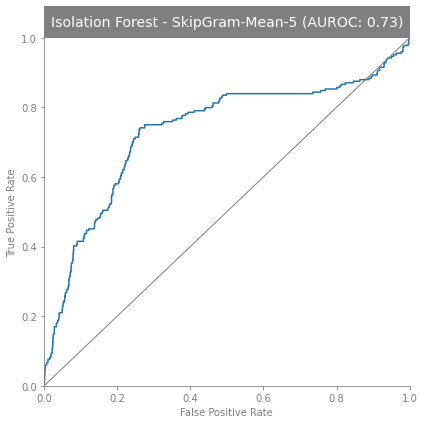

Test:
	Accuracy:    73.82%
	Precision:   32.58%
	Recall:      74.52%
	F1-score:    45.34%
	auROC:       73.11%
                                    SkipGram-Sum-10                                     
Validation:
	Accuracy:    61.04%
	Precision:   21.32%
	Recall:      62.05%
	F1-score:    31.74%


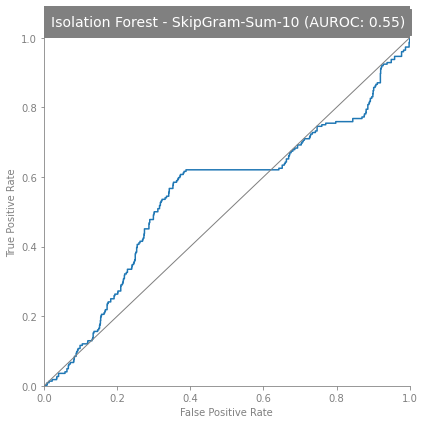

Test:
	Accuracy:    61.60%
	Precision:   21.42%
	Recall:      61.30%
	F1-score:    31.75%
	auROC:       54.71%
                                    SkipGram-Mean-10                                    
Validation:
	Accuracy:    82.61%
	Precision:   42.24%
	Recall:      52.23%
	F1-score:    46.71%


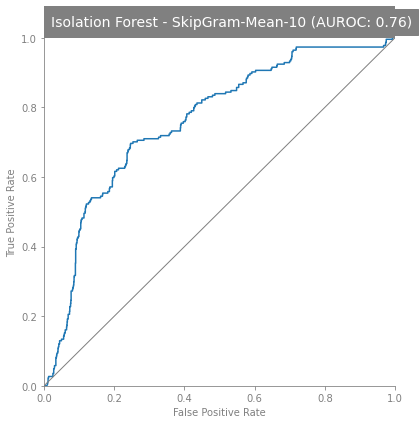

Test:
	Accuracy:    81.97%
	Precision:   40.58%
	Recall:      51.15%
	F1-score:    45.25%
	auROC:       74.60%
                                    SkipGram-Sum-20                                     
Validation:
	Accuracy:    68.53%
	Precision:   24.05%
	Recall:      53.57%
	F1-score:    33.20%


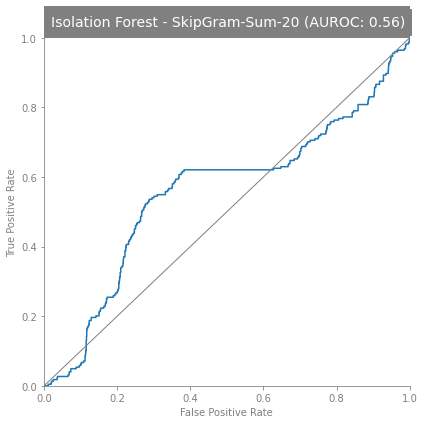

Test:
	Accuracy:    68.24%
	Precision:   23.49%
	Recall:      52.30%
	F1-score:    32.42%
	auROC:       55.38%
                                    SkipGram-Mean-20                                    
Validation:
	Accuracy:    69.84%
	Precision:   28.47%
	Recall:      70.54%
	F1-score:    40.56%


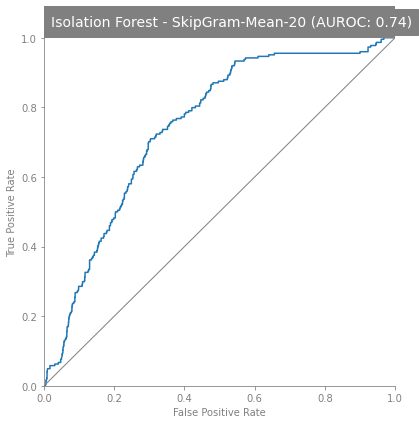

Test:
	Accuracy:    68.74%
	Precision:   26.96%
	Recall:      67.05%
	F1-score:    38.46%
	auROC:       73.73%


In [ ]:
for name, train, valid, test in representations:
    # Header.
    print("=" * 88 + f"\n{name:^88}\n" + "=" * 88)

    # Prediction.
    y_pred, score, model, best_t = iso_forest(train, valid, y_valid)

    # Metrics.
    metrics(y_valid, y_pred, "Validation")

    # Plots.
    show_confusion_matrix(y_valid, y_pred)
    plot_roc_curve(y_valid, score, f"Isolation Forest - {name}")

    # Predict on the test set.
    score = -1 * model.score_samples(test)
    y_pred = [1 if s > best_t else 0 for s in score]

    # Metrics.
    metrics(y_test, y_pred, "Test")
    print(f"\t{'auROC:':12s} {roc_auc_score(y_test, score):.2%}")

## One Class SVM

                                      Bag of Word                                       
Validation:
	Accuracy:    71.40%
	Precision:   25.51%
	Recall:      50.00%
	F1-score:    33.79%


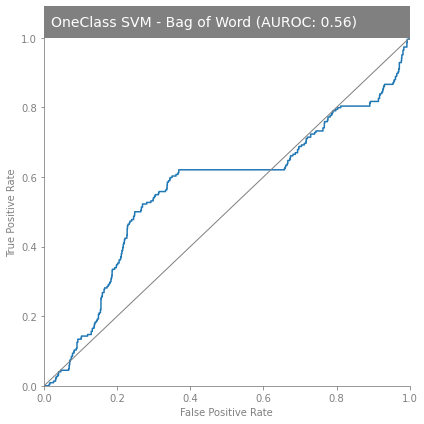

Test:
	Accuracy:    71.87%
	Precision:   25.89%
	Recall:      50.00%
	F1-score:    34.12%
	auROC:       56.39%
                                         TF-IDF                                         
Validation:
	Accuracy:    77.98%
	Precision:   36.23%
	Recall:      66.96%
	F1-score:    47.02%


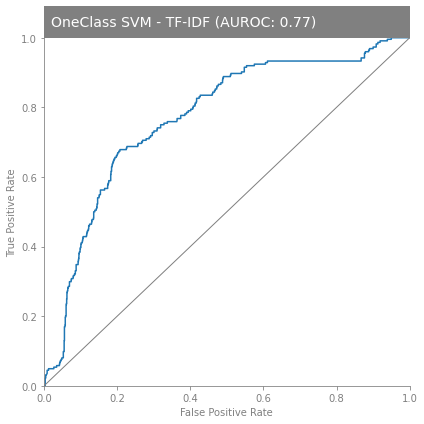

Test:
	Accuracy:    77.42%
	Precision:   35.04%
	Recall:      64.37%
	F1-score:    45.37%
	auROC:       75.77%
                                         LDA-5                                          
Validation:
	Accuracy:    65.60%
	Precision:   19.72%
	Recall:      44.20%
	F1-score:    27.27%


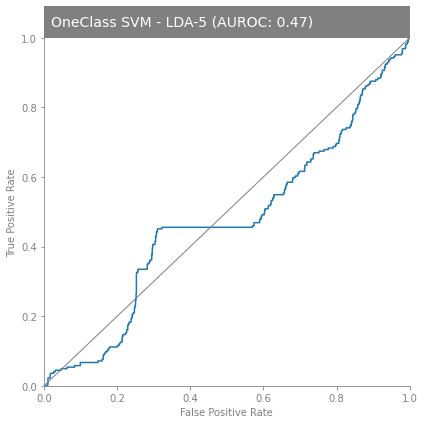

Test:
	Accuracy:    65.22%
	Precision:   19.83%
	Recall:      45.59%
	F1-score:    27.64%
	auROC:       49.49%
                                         LDA-10                                         
Validation:
	Accuracy:    85.41%
	Precision:   50.00%
	Recall:      30.80%
	F1-score:    38.12%


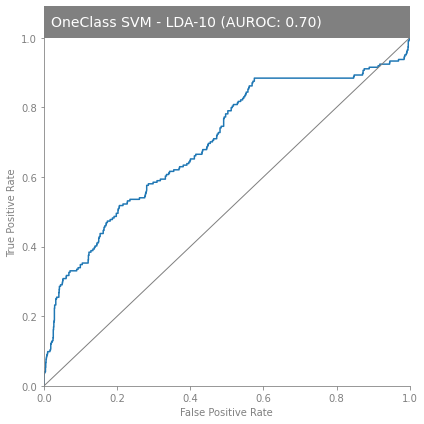

Test:
	Accuracy:    84.40%
	Precision:   44.48%
	Recall:      28.54%
	F1-score:    34.77%
	auROC:       71.46%
                                         LDA-20                                         
Validation:
	Accuracy:    71.66%
	Precision:   27.88%
	Recall:      59.38%
	F1-score:    37.95%


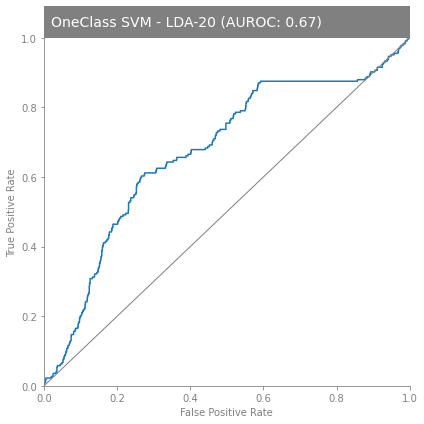

Test:
	Accuracy:    71.95%
	Precision:   28.98%
	Recall:      63.79%
	F1-score:    39.86%
	auROC:       69.01%
                                     SkipGram-Sum-5                                     
Validation:
	Accuracy:    68.40%
	Precision:   22.53%
	Recall:      47.77%
	F1-score:    30.62%


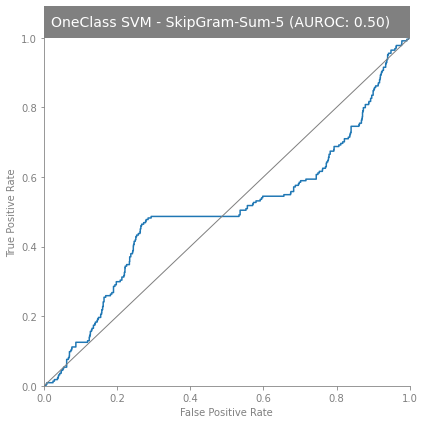

Test:
	Accuracy:    68.74%
	Precision:   22.62%
	Recall:      47.32%
	F1-score:    30.61%
	auROC:       50.62%
                                    SkipGram-Mean-5                                     
Validation:
	Accuracy:    83.71%
	Precision:   43.09%
	Recall:      36.16%
	F1-score:    39.32%


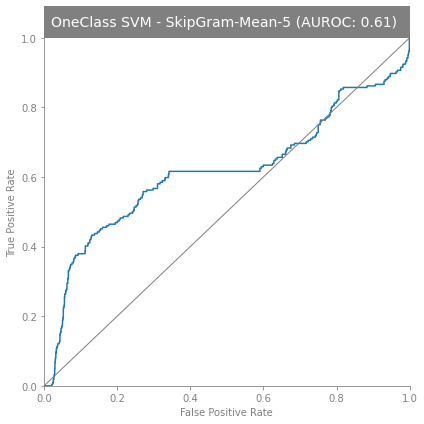

Test:
	Accuracy:    83.45%
	Precision:   42.33%
	Recall:      37.55%
	F1-score:    39.80%
	auROC:       62.67%
                                    SkipGram-Sum-10                                     


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation:
	Accuracy:    64.69%
	Precision:   21.51%
	Recall:      53.57%
	F1-score:    30.69%


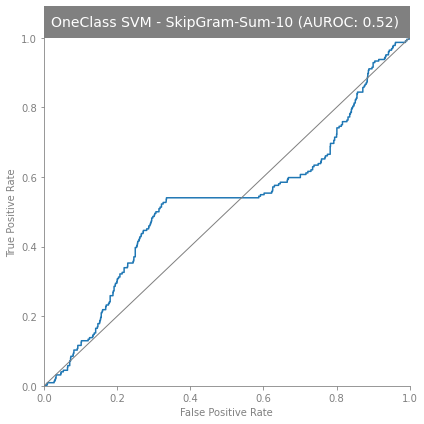

Test:
	Accuracy:    65.00%
	Precision:   21.93%
	Recall:      54.79%
	F1-score:    31.33%
	auROC:       53.86%
                                    SkipGram-Mean-10                                    
Validation:
	Accuracy:    77.46%
	Precision:   32.37%
	Recall:      50.00%
	F1-score:    39.30%


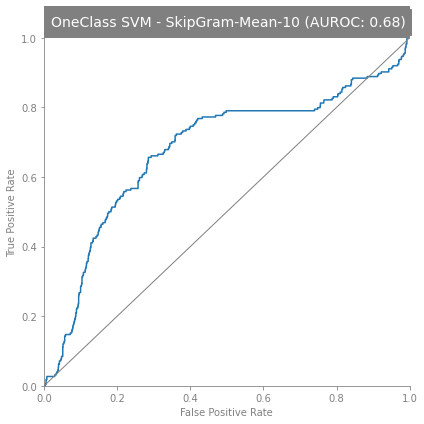

Test:
	Accuracy:    76.64%
	Precision:   30.14%
	Recall:      45.79%
	F1-score:    36.35%
	auROC:       67.77%
                                    SkipGram-Sum-20                                     
Validation:
	Accuracy:    66.78%
	Precision:   23.02%
	Recall:      54.46%
	F1-score:    32.36%


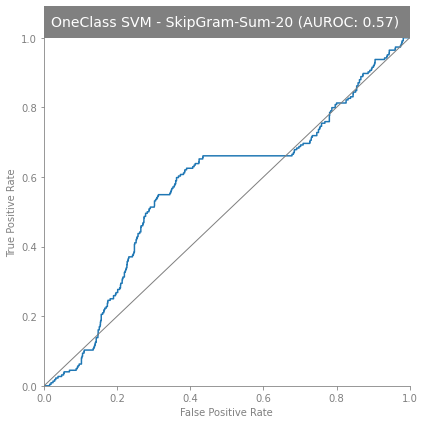

Test:
	Accuracy:    67.12%
	Precision:   22.94%
	Recall:      53.26%
	F1-score:    32.06%
	auROC:       56.50%
                                    SkipGram-Mean-20                                    
Validation:
	Accuracy:    69.71%
	Precision:   28.67%
	Recall:      72.32%
	F1-score:    41.06%


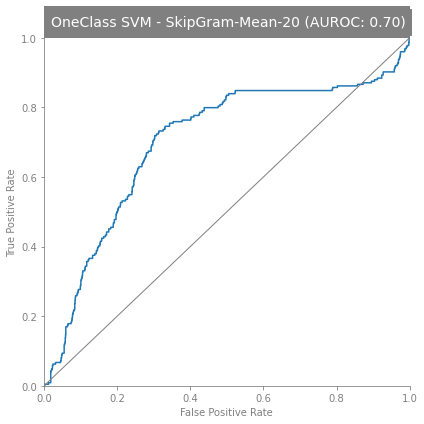

Test:
	Accuracy:    68.77%
	Precision:   27.57%
	Recall:      70.31%
	F1-score:    39.61%
	auROC:       70.83%


In [ ]:
for name, train, valid, test in representations:
    # Header.
    print("=" * 88 + f"\n{name:^88}\n" + "=" * 88)

    # Prediction.
    y_pred, score, model, best_t = svm(train, valid, y_valid)

    # Metrics.
    metrics(y_valid, y_pred, "Validation")

    # Plots.
    show_confusion_matrix(y_valid, y_pred)
    plot_roc_curve(y_valid, score, f"OneClass SVM - {name}")

    # Predict on the test set.
    score = -1 * model.score_samples(test)
    y_pred = [1 if s > best_t else 0 for s in score]

    # Metrics.
    metrics(y_test, y_pred, "Test")
    print(f"\t{'auROC:':12s} {roc_auc_score(y_test, score):.2%}")